**Topic**:        Challenge Set 1  
**Subject**:      Explore MTA turnstile data  
**Date**:         7/1/2017  
**Name**:         Joseph Eddy  
**Worked with**:  Project Benson Team: Devin Maiello, Will Tseng, Matt Orr  

**Challenge 1**: Create dictionary with (C/A, UNIT, SCP, STATION) keys

We'll read the 5 latest files into dataframes, concat them and clean the header, then iterate through the rows of the dataframe to create a dictionary with the specified format.

In [1]:
import pandas as pd
import numpy as np

df_MTA1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170527.txt')
df_MTA2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170603.txt')
df_MTA3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170610.txt')
df_MTA4 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170617.txt')
df_MTA5 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170624.txt')

df_MTA = pd.concat([df_MTA1,df_MTA2,df_MTA3,df_MTA4,df_MTA5])
df_MTA.columns = df_MTA.columns.str.strip()

In [2]:
df_MTA.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/20/2017,00:00:00,REGULAR,6184841,2095161
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/20/2017,04:00:00,REGULAR,6184865,2095167
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/20/2017,08:00:00,REGULAR,6184891,2095192
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/20/2017,12:00:00,REGULAR,6184973,2095275
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/20/2017,16:00:00,REGULAR,6185217,2095326


In [3]:
C1_dict = {}
for _, row in df_MTA.iterrows():
    key = tuple(row[df_MTA.columns[0:4]].values)
    val = list(row[df_MTA.columns[4:]].values)
    C1_dict[key] = C1_dict.get(key,[]) + [val]   

Now check that the dictionary formatting is correct (output supressed due to length):

In [4]:
C1_dict[('A002','R051','02-00-00','59 ST')];

**Challenge 2**: Create new dictionary with the same keys, but time series values

In [5]:
import dateutil.parser

C2_dict = {}
for _, row in df_MTA.iterrows():
    key = tuple(row[df_MTA.columns[0:4]].values)
    datetime_str = row['DATE'] + ' ' + row['TIME']
    datetime_parsed = dateutil.parser.parse(datetime_str) 
    val = [datetime_parsed,row['ENTRIES']]
    C2_dict[key] = C2_dict.get(key,[]) + [val]

In [6]:
C2_dict[('A002','R051','02-00-00','59 ST')];

**Challenge 3**: Create new dictionary with the same keys, but a single entry count per turnstile for each day.

The approach we use for this is to group the dataframe by turnstile identifying and date columns and aggregate the entry column by taking minumums. Since the entry column tracks cumulative entries, for any given day the total entries should be given by the difference between the min of next day's entry values and the min of this day's entry values. For the last day in the data set we don't have the entirety of the daily entries counted, so we'll set the count to NaN.

In [7]:
df_MTA_byDate = df_MTA.groupby(['C/A','UNIT','SCP','STATION','DATE']).ENTRIES.agg({'MIN_ENTRIES':'min'})
df_MTA_byDate = df_MTA_byDate.reset_index()

df_MTA_byDate['DAILY_ENTRIES'] = df_MTA_byDate.groupby(['C/A','UNIT','SCP','STATION']).MIN_ENTRIES.diff().shift(-1)

Fix up this df and set the negative entry values or excessively large entry values to NaN (invalid, something went wrong with the cumulative count). Then take a look.

In [8]:
df_MTA_byDate.drop('MIN_ENTRIES',axis=1,inplace=True) 
df_MTA_byDate.loc[df_MTA_byDate['DAILY_ENTRIES'] < 0, 'DAILY_ENTRIES'] = np.nan
df_MTA_byDate.loc[df_MTA_byDate['DAILY_ENTRIES'] > 100000, 'DAILY_ENTRIES'] = np.nan
df_MTA_byDate.head(7)

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRIES
0,A002,R051,02-00-00,59 ST,05/20/2017,793.0
1,A002,R051,02-00-00,59 ST,05/21/2017,581.0
2,A002,R051,02-00-00,59 ST,05/22/2017,1461.0
3,A002,R051,02-00-00,59 ST,05/23/2017,1807.0
4,A002,R051,02-00-00,59 ST,05/24/2017,2005.0
5,A002,R051,02-00-00,59 ST,05/25/2017,2094.0
6,A002,R051,02-00-00,59 ST,05/26/2017,1635.0


Now create the corresponding dictionary, then check that it looks right:

In [9]:
import dateutil.parser

C3_dict = {}
for _, row in df_MTA_byDate.iterrows():
    key = tuple(row[df_MTA_byDate.columns[0:4]].values)
    datetime_str = row['DATE']
    datetime_parsed = dateutil.parser.parse(datetime_str) 
    val = [datetime_parsed,row['DAILY_ENTRIES']]
    C3_dict[key] = C3_dict.get(key,[]) + [val]

In [10]:
C3_dict[('A002','R051','02-00-00','59 ST')];

**Challenge 4**: Plot the daily time series for a turnstile

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
turnstile_lists = C3_dict[('A002','R051','02-00-00','59 ST')]
dates, counts = [], []
for turnstile_list in turnstile_lists:
    dates += [turnstile_list[0]]
    counts += [turnstile_list[1]]

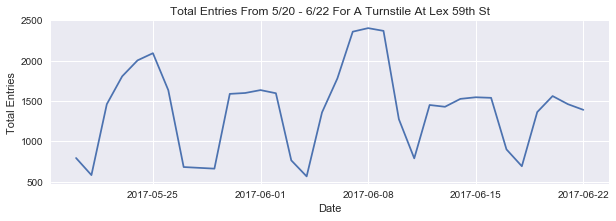

In [13]:
plt.figure(figsize=(10,3))
plt.plot(dates,counts)
plt.title('Total Entries From 5/20 - 6/22 For A Turnstile At Lex 59th St')
plt.xlabel('Date')
plt.ylabel('Total Entries')

**Challenge 5**: combine turnstiles into single C/A,Unit,Station daily counts

In [14]:
df_MTA_TurnComb = df_MTA_byDate.reset_index().drop('SCP',axis=1)
df_MTA_TurnComb = df_MTA_byDate.groupby(['C/A','UNIT','STATION','DATE']).DAILY_ENTRIES.agg({'DAILY_ENTRIES':'sum'})

df_MTA_TurnComb.head(7)

DAILY_ENTRIES
C/A  UNIT STATION DATE                     
A002 R051 59 ST   05/20/2017         8167.0
                  05/21/2017         6599.0
                  05/22/2017        13520.0
                  05/23/2017        14735.0
                  05/24/2017        15060.0
                  05/25/2017        14729.0
                  05/26/2017        14363.0

**Challenge 6**: combine turnstiles into single Station daily counts

In [15]:
df_MTA_StatComb = df_MTA_TurnComb.reset_index().drop(['C/A','UNIT'],axis=1)
df_MTA_StatComb = df_MTA_StatComb.groupby(['STATION','DATE']).DAILY_ENTRIES.agg({'DAILY_ENTRIES':'sum'})

df_MTA_StatComb.head(7)

DAILY_ENTRIES
STATION DATE                     
1 AV    05/20/2017        19115.0
        05/21/2017        13845.0
        05/22/2017        22031.0
        05/23/2017        23029.0
        05/24/2017        23619.0
        05/25/2017        23778.0
        05/26/2017        23282.0

**Challenge 7**: Plot the daily time series for a single station

In [16]:
df_MTA_StatComb = df_MTA_StatComb.reset_index()
df_MTA_Stat59 = df_MTA_StatComb[df_MTA_StatComb['STATION'] == '59 ST']

dates = [dateutil.parser.parse(date) for date in df_MTA_Stat59['DATE'].values]
counts = df_MTA_Stat59['DAILY_ENTRIES'].values

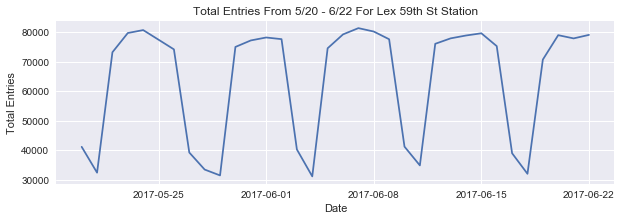

In [17]:
plt.figure(figsize=(10,3))
plt.plot(dates,counts)
plt.title('Total Entries From 5/20 - 6/22 For Lex 59th St Station')
plt.xlabel('Date')
plt.ylabel('Total Entries')

**Challenge 8**: Plot the daily time series for a single station, but across several different weeks

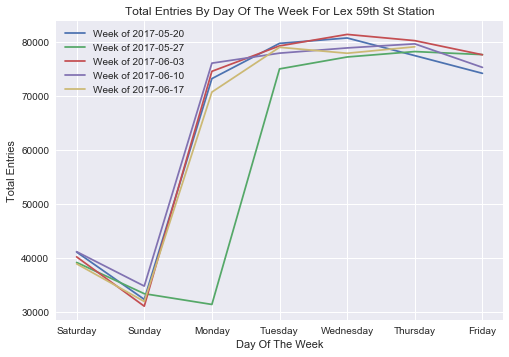

In [18]:
days_list = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']

plt.figure(figsize=(10,3))
fig, ax = plt.subplots()

labels = []
for i in range(0,5):
    plt.plot(list(range(0,7)),counts[i*7:(i+1)*7])
    labels.append('Week of ' + str(dates[i*7].date()))

plt.title('Total Entries By Day Of The Week For Lex 59th St Station')
plt.xticks(range(7),days_list)
plt.xlabel('Day Of The Week')
plt.ylabel('Total Entries')

ax.legend(labels, loc='best')
plt.show()

Two things to note about the chart above: first, that the missing data point for Friday 6/23 is correct - we aren't able to properly calculate daily entries for that date since it is the last one in our data (see challenge 3 above). Second, the low Monday 5/29 data point is expected, since this was Memorial Day.

**Challenge 9**: Sum total ridership for each station over multiple weeks and sort them to find those with the highest traffic.

In [19]:
df_MTA_StatTotal = df_MTA_StatComb.groupby('STATION')['DAILY_ENTRIES'].sum()
df_MTA_StatTotal.sort_values(ascending=False,inplace=True)
df_MTA_StatTotal.head(10)

STATION
34 ST-PENN STA     4875396.0
GRD CNTRL-42 ST    4143627.0
34 ST-HERALD SQ    3464068.0
23 ST              3271208.0
14 ST-UNION SQ     3200567.0
TIMES SQ-42 ST     3056531.0
42 ST-PORT AUTH    2752735.0
FULTON ST          2649609.0
86 ST              2614758.0
125 ST             2257384.0
Name: DAILY_ENTRIES, dtype: float64

Unsuprisingly, the highest traffic stations are major commuter and tourist hubs like Penn Station, Grand Central, Herald Square, and Times Square.

**Challenge 10**: Plot the distribution of total ridership by station.

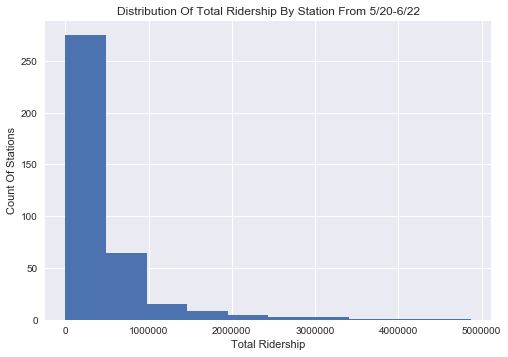

In [20]:
df_MTA_StatTotal.hist()

#Alternatively do it by creating a seperate list as below, but this is little less code efficient! 
#total_ridership_counts = list(df_MTA_StatTotal)
#plt.hist(total_ridership_counts)

plt.title('Distribution Of Total Ridership By Station From 5/20-6/22')
plt.xlabel('Total Ridership')
plt.ylabel('Count Of Stations')

As expected, total ridership by station is right-skewed: most stations have small traffic volume while only a small number have extremely large traffic volume.